In [1]:
from __future__ import division

from time import time
import sys
import curses

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Dropout, Activation, Flatten, Reshape
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.utils import np_utils
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar100

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [10]:
class Generator:
    
    def __init__(self, input_size):
        self.model = Sequential()
#         self.model.add(Dense(hidden_size, input_shape = (input_size,), activation = "elu"))
        self.model.add(Dense(64 * 7 * 7, input_shape=(input_size,), activation = "tanh"))
        self.model.add(Reshape((64, 7, 7)))
        self.model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=16, kernel_size=(5, 5), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=1, kernel_size=(3, 3), padding="same", use_bias=True,
                      activation="tanh", data_format="channels_first"))
        
    def compileModel(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, **kwargs):
        return self.model.train_on_batch(**kwargs)

In [11]:
class Discriminator:
    
    def __init__(self, output_size):
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=5, padding="same", use_bias=True,
                                     input_shape=(1, img_rows, img_cols), activation="tanh", data_format="channels_first"))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(filters=16, kernel_size=5, padding="same", use_bias=True,
                              activation="tanh", data_format="channels_first"))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(output_size, activation = "sigmoid"))
    
    def compileModel(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, X, Y):
        return self.model.train_on_batch(X, Y)
    
    def trainable(self, trainable):
        self.model.trainable = trainable

In [4]:
class GeneratorAndDiscriminator:
    
    def __init__(self, generator, discriminator):
        self.model = Sequential()
        self.model.add(generator)
        self.model.add(discriminator)
        
    def compileModel(self, **kwargs):
        self.model.compile(**kwargs)
        
    def predict(self, X):
        return self.model.predict(X)
        
    def train_on_batch(self, X, Y):
        return self.model.train_on_batch(X, Y)

In [14]:
def print_progress(stdscr, epoch, epochs, minibatch, minibatches, start_time, g_loss, d_loss):
    
    bar_length = 50
    
    progress_bar = "[" + "=" * int(bar_length * epoch / epochs) + \
    ">" + "-" * int(bar_length * (epochs - epoch) / epochs) + "]"
    
    time_taken = (time() - start_time)
    
    minibatches_complete = epoch * minibatches + minibatch
    total_minibatches = epochs * minibatches
    
    secs = np.ceil(time_taken * total_minibatches / minibatches_complete - time_taken)
    hours = np.floor(secs / 3600)
    secs -= hours * 3600
    mins = np.floor(secs / 60)
    secs -= mins * 60
    
    stdscr.addstr(0, 0 , "Epoch: {}/{} minibatch: {}/{} ".format(epoch, epochs, minibatch, minibatches) + 
                  progress_bar + 
                  " {}% ETA: {}h {}m {}s".format(int(epoch * 100 / epochs), int(hours), int(mins), int(secs)))
    stdscr.addstr(1, 0, "g_loss: {} ".format(g_loss[0]) + "g_acc: {} ".format(g_loss[1]) + 
                     "d_loss: {} ".format(d_loss[0]) + "d_acc: {}".format(d_loss[1]))
    stdscr.refresh()

In [22]:
for i in range(100):
    stdscr.addstr(0, 0 , "Epoch: {}/{}".format(i, 100))
    stdscr.refresh()

In [15]:
# Model params
g_input_size = 100    # Random noise dimension coming into generator, per output vector
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

# Data params
nb_classes = 10
img_rows, img_cols = 28, 28

In [16]:
##load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##reshape data
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#centre data on zero
x_train = (x_train - 255 / 2) / (255 / 2)
x_test = (x_test - 255 / 2) / (255 / 2)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

num_epochs = 10
d_steps = 1 # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

#parameter settings
minibatch_size = 128

num_patterns = len(x_train)
num_minibatches = int(num_patterns / minibatch_size)

In [17]:
#construct generator
G = Generator(g_input_size)

#compile G
G.compileModel(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

#construct discriminator
D = Discriminator( d_output_size)

#compile D
D.compileModel(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

##generator and discriminator
GD = GeneratorAndDiscriminator(G.model, D.model)

#compile GD
GD.compileModel(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# %%time

'''
main loop
'''

stdscr = curses.initscr()
curses.noecho()
curses.cbreak()

start_time = time()

for epoch in range(1, num_epochs+1):
        
    for minibatch in range(num_minibatches):
        
        '''
        train D
        '''

        #get real data
        d_real_data = x_train[minibatch * minibatch_size : (minibatch + 1) * minibatch_size]
#         print d_real_data.shape
        d_real_targets = np.ones(minibatch_size)

        #generate fake data
        d_gen_input = np.random.uniform(-1, 1, size=(minibatch_size, g_input_size))
        d_fake_data = G.predict(d_gen_input)
#         print d_fake_data.shape
        d_fake_targets = np.zeros(minibatch_size)

        #combine real and fake data
        d_data = np.append(d_real_data, d_fake_data, axis=0)
        d_targets = np.append(d_real_targets, d_fake_targets)

        #fit discriminator
        D.trainable(True)
#         d_loss = D.train_on_batch(d_data, d_targets, shuffle=True, epochs=epochs,
#               batch_size=1, validation_split=0.0, verbose=0)
        d_loss = D.train_on_batch(d_data, d_targets)
        
        '''
        train G
        '''
        
        #generate data from noise
        g_gen_input = np.random.uniform(-1, 1, size=(minibatch_size, g_input_size))
        
        #target
        g_targets = np.ones(minibatch_size)
        
        #fit generator
        D.trainable(False)
#         g_loss = GD.train_on_batch(gen_input, target, shuffle=True, epochs=epochs,
#               batch_size=1, validation_split=0.0, verbose=0)
        g_loss = GD.train_on_batch(g_gen_input, g_targets)
        
        print_progress(stdscr, epoch, num_epochs, minibatch, num_minibatches, start_time, g_loss, d_loss)

print "\nDONE"

KeyboardInterrupt: 

In [ ]:
i = 5
plt.imshow(x_train[i:i+1, 0])
plt.show()

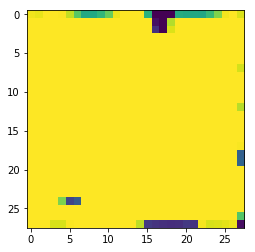

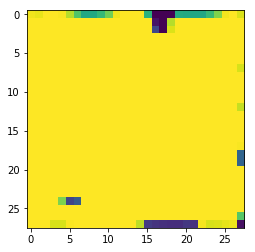

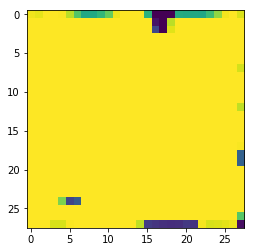

[[  1.18774430e-08]
 [  1.17817081e-08]
 [  1.16360104e-08]]


In [17]:
num_samples = 3

gen_input = gi_sampler(num_samples, g_input_size)
forgery = G.model.predict(gen_input)

# print np.mean(forgery)


for i in range(num_samples):

    plt.imshow(forgery[i ,0])
    plt.show()

print D.model.predict(forgery)

In [18]:
forgery[0,0]

array([[ 0.95926702,  0.93024564,  0.99963713,  0.99983162,  0.98766541,
         0.82020974,  0.48736143,  0.20591736,  0.21359053,  0.32458568,
         0.53126395,  0.94952166,  0.99957955,  0.99996644,  0.99996901,
         0.27559862, -0.99999994, -1.        , -0.99999708,  0.23608355,
         0.21488442,  0.20319615,  0.20258303,  0.35423985,  0.62418109,
         0.96343535,  0.99965781,  0.88318092],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  0.99999994,  0.99999994,  0.99999994,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        , -0.91377282, -0.99999708,  0.76959276,  0.99999994,
         0.99999994,  0.99999994,  0.99999994,  0.99999994,  1.        ,
         1.        ,  1.        ,  0.99999994],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  0.99999994,  0.99999994,  0.99999994,
         0.99999994,  0.9999

In [40]:
gi_sampler(num_samples, g_input_size)

array([[ 0.64774901,  0.47213832,  0.83213407,  0.20773771,  0.63707203,
         0.23384756,  0.44012588,  0.38610521,  0.10582925,  0.59061027],
       [ 0.5742842 ,  0.67586386,  0.62400943,  0.75729132,  0.49189976,
         0.91653287,  0.82447982,  0.60402727,  0.58924794,  0.39663929],
       [ 0.12640612,  0.53640133,  0.22328959,  0.60326886,  0.77125293,
         0.19539379,  0.05754237,  0.97403169,  0.5050801 ,  0.44795224]], dtype=float32)